# More advanced filtering and plotting

I don't know if I will get to this in the workshop.. But it's here if you want it!

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import STOPWORDS, WordCloud

warnings.filterwarnings('ignore')  # bad idea

Load changeset data...

In [2]:
df = pd.read_csv("../data/changesets.csv", parse_dates=["created_at", "closed_at"])

# Convert 'created_at' and 'closed_at' to Mountain Time
if df["created_at"].dt.tz:
    df["created_at"] = df["created_at"].dt.tz_convert("US/Mountain")
else:
    df["created_at"] = (
        df["created_at"].dt.tz_localize("UTC").dt.tz_convert("US/Mountain")
    )

if df["closed_at"].dt.tz:
    df["closed_at"] = df["closed_at"].dt.tz_convert("US/Mountain")
else:
    df["closed_at"] = df["closed_at"].dt.tz_localize("UTC").dt.tz_convert("US/Mountain")

Filter out most active users (>1000 changes)

If you want 'others' included in the chart, comment out all the lines that operate on 'user' and uncomment those that operate on 'user_category'

In [4]:
# Group by user and count total changesets
user_changesets_total = df.groupby('user').size()

# Replace the user name in df with 'others' for users with less than 1000 changesets
# df['user_category'] = df['user'].apply(lambda x: 'others' if pd.isna(x) or user_changesets_total[x] < 1000 else x)

# Now, filter only the active users and 'others' 
active_users = user_changesets_total[user_changesets_total >= 1000].index.tolist()
active_users.append('others')

df_filtered = df[df["user"].isin(active_users)]
# df_filtered = df[df["user_category"].isin(active_users)]

print(df_filtered['user'].value_counts())
# print(df_filtered['user_category'].value_counts())

# After categorizing users and filtering
df_filtered["year_month"] = df_filtered["created_at"].dt.to_period("M")

# Now, group and pivot data using 'user_category'
activity_count = df_filtered.groupby(['year_month', 'user']).size().reset_index(name='activity_count')
activity_pivot = activity_count.pivot(index='year_month', columns='user', values='activity_count').fillna(0)
# activity_count = df_filtered.groupby(['year_month', 'user_category']).size().reset_index(name='activity_count')
# activity_pivot = activity_count.pivot(index='year_month', columns='user_category', values='activity_count').fillna(0)
activity_percentage = activity_pivot.divide(activity_pivot.sum(axis=1), axis=0) * 100

# Now, smooth the data
activity_percentage_smoothed = activity_percentage.rolling(window=3).mean()

# Ensure it's still a 100% stacked area chart
# activity_percentage_smoothed = activity_percentage_smoothed.divide(activity_percentage_smoothed.sum(axis=1), axis=0) * 100

total_changesets_per_user_cat = df_filtered.groupby('user').size().sort_values(ascending=False)
# total_changesets_per_user_cat = df_filtered.groupby('user_category').size().sort_values(ascending=False)
sorted_users = total_changesets_per_user_cat.index.tolist()

activity_percentage_sorted = activity_percentage_smoothed[sorted_users]

user
mvexel          14637
Tetzemann82      9291
atlas-3d         4709
Val              4482
aweech           4282
Xvtn             4173
kevinp2          3286
mash84121        2686
esetzer          2499
butlerm          2464
tcarlisle        2147
OremSteve        2020
PacOce           1966
dknelson9876     1917
chadbunn         1657
Airfall          1537
Sytys            1411
Tindog           1313
Jayden928        1137
Oregonian3       1099
TheConductor     1086
robertstats      1063
Name: count, dtype: int64


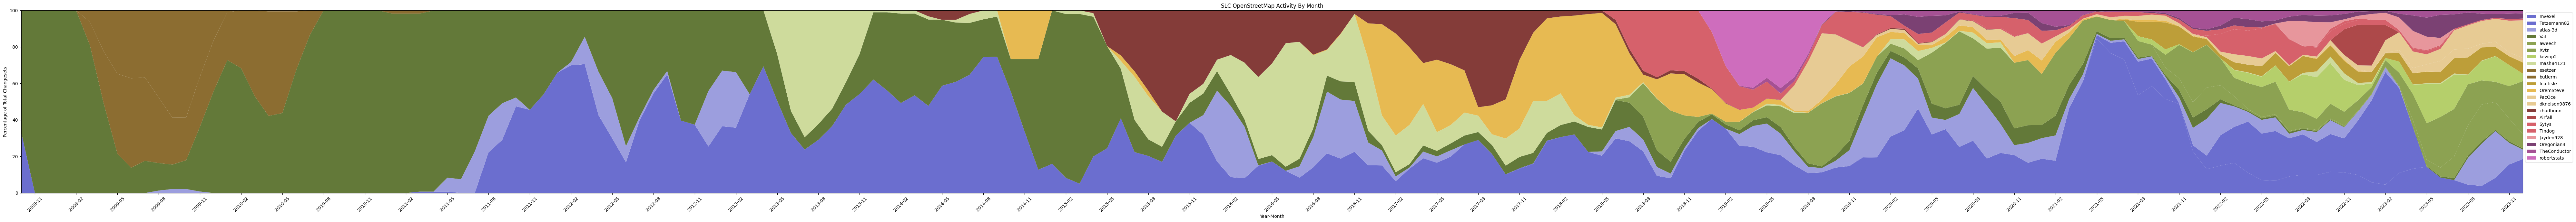

In [5]:

# Color mapping
colormap = plt.cm.tab20b
# colormap = plt.cm.terrain.reversed()

# pick colors from the range so they entire colormap is used
# but leave out the first 10 colors as they are too light

distinct_colors = [colormap(i) for i in np.linspace(0.1, 0.9, len(activity_percentage_sorted.columns))]
#distinct_colors = [colormap(i) for i in np.linspace(0, 0.9, len(activity_percentage_sorted.columns))]
#distinct_colors = [colormap(i) for i in range(len(activity_percentage_sorted.columns))]

plt.figure(figsize=(80, 7))
plt.stackplot(activity_percentage_sorted.index.astype(str), activity_percentage_sorted.T, labels=activity_percentage_sorted.columns, colors=distinct_colors)
plt.title('SLC OpenStreetMap Activity By Month')
plt.xlabel('Year-Month')
plt.ylabel('Percentage of Total Changesets')

plt.xticks(activity_percentage.index[::3].astype(str), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.xticks(rotation=45)
# make sure we have no empty area before the first and after the last data point
plt.margins(0, 0)

plt.tight_layout()
plt.show()

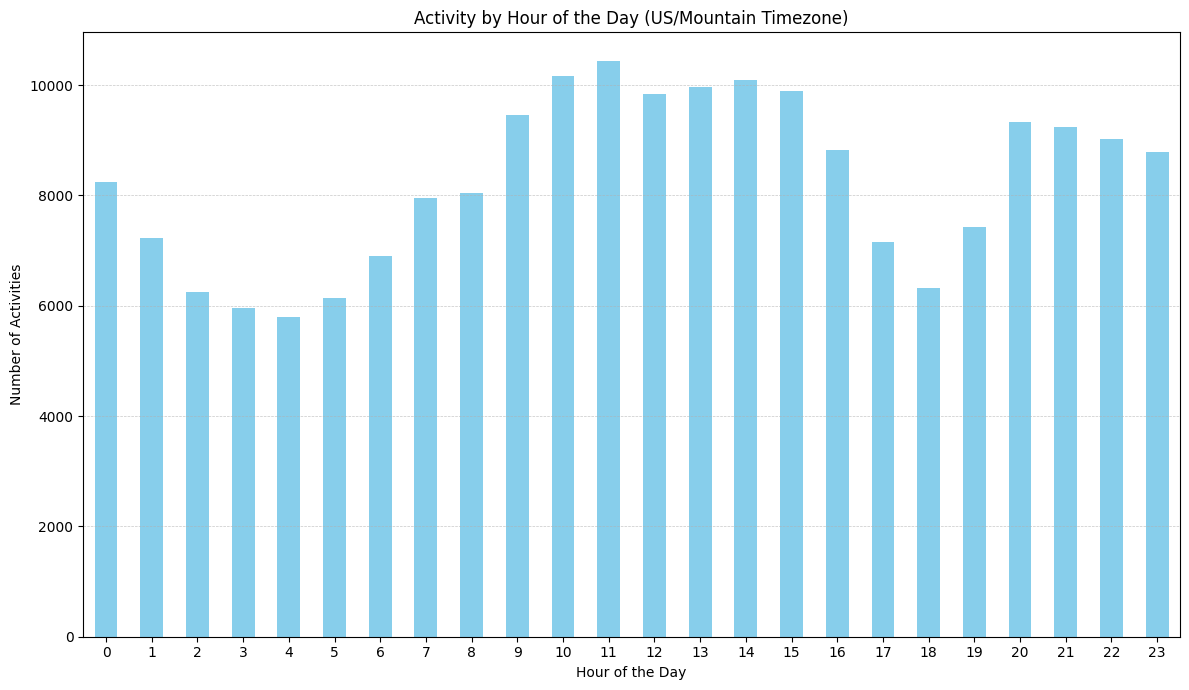

In [6]:
df['hour_of_day'] = df['created_at'].dt.hour
hourly_activity = df.groupby('hour_of_day').size()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
hourly_activity.plot(kind='bar', color='skyblue')
plt.title('Activity by Hour of the Day (US/Mountain Timezone)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Activities')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

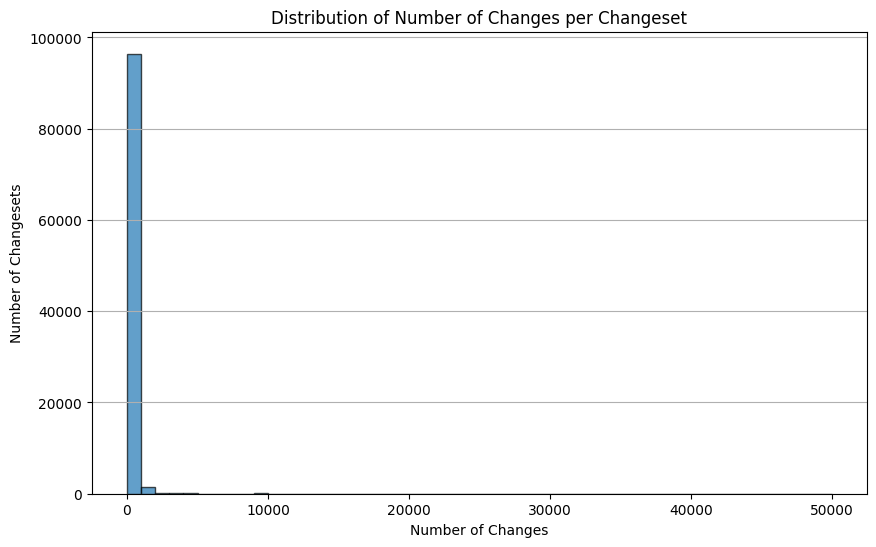

In [7]:

df_filtered = df[df['num_changes'] > 10]  # set to >0 to include single change changesets

plt.figure(figsize=(10, 6))
plt.hist(df_filtered['num_changes'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Changes per Changeset')
plt.xlabel('Number of Changes')
plt.ylabel('Number of Changesets')
plt.grid(axis='y')
plt.show()

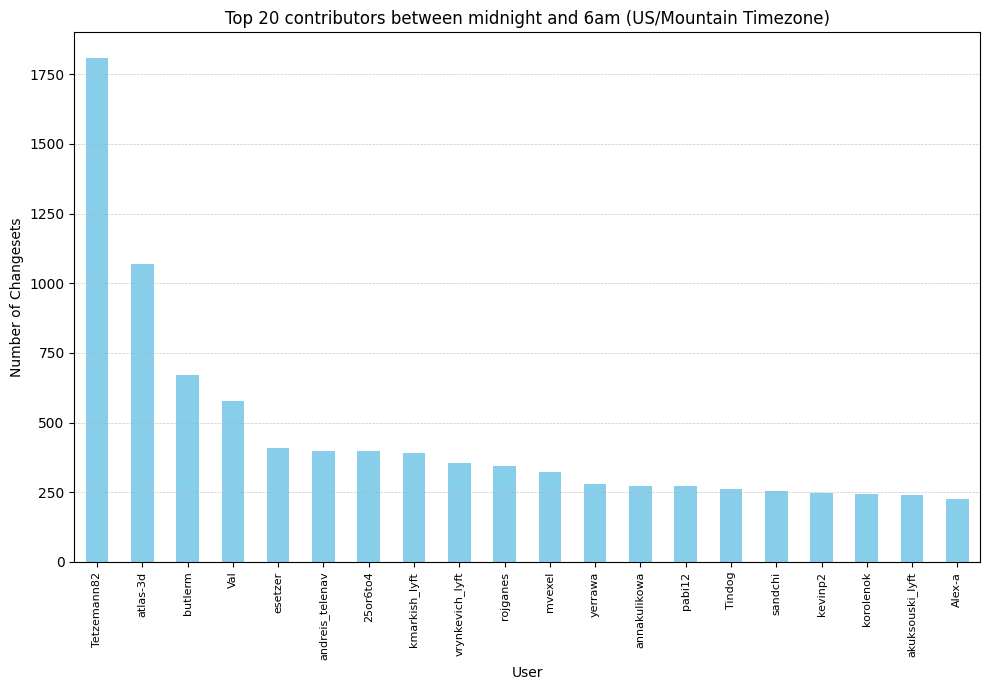

In [8]:
# get all the users that edit between 00:00 and 06:00 in the morning
df['hour_of_day'] = df['created_at'].dt.hour
df['is_night'] = df['hour_of_day'].apply(lambda x: True if x >= 0 and x <= 6 else False)
night_users = df[df['is_night'] == True]['user'].unique().tolist()

# for these night_users, compute the number of changesets created between 00:00 and 06:00
df_night_users = df[df['user'].isin(night_users)]
df_night_users['hour_of_day'] = df_night_users['created_at'].dt.hour
df_night_users['is_night'] = df_night_users['hour_of_day'].apply(lambda x: True if x >= 0 and x <= 6 else False)
night_changesets = df_night_users[df_night_users['is_night'] == True]

# plot the top 20 night users as a bar chart
top_night_users = night_changesets['user'].value_counts().head(20)
plt.figure(figsize=(10, 7))
top_night_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 contributors between midnight and 6am (US/Mountain Timezone)')
plt.xlabel('User')
plt.ylabel('Number of Changesets')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

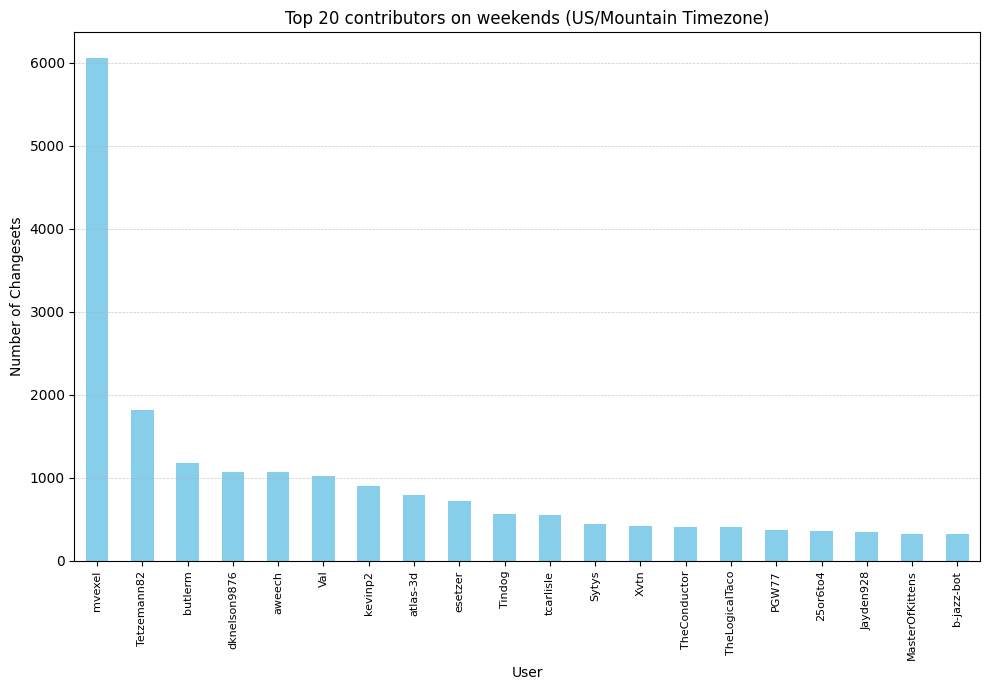

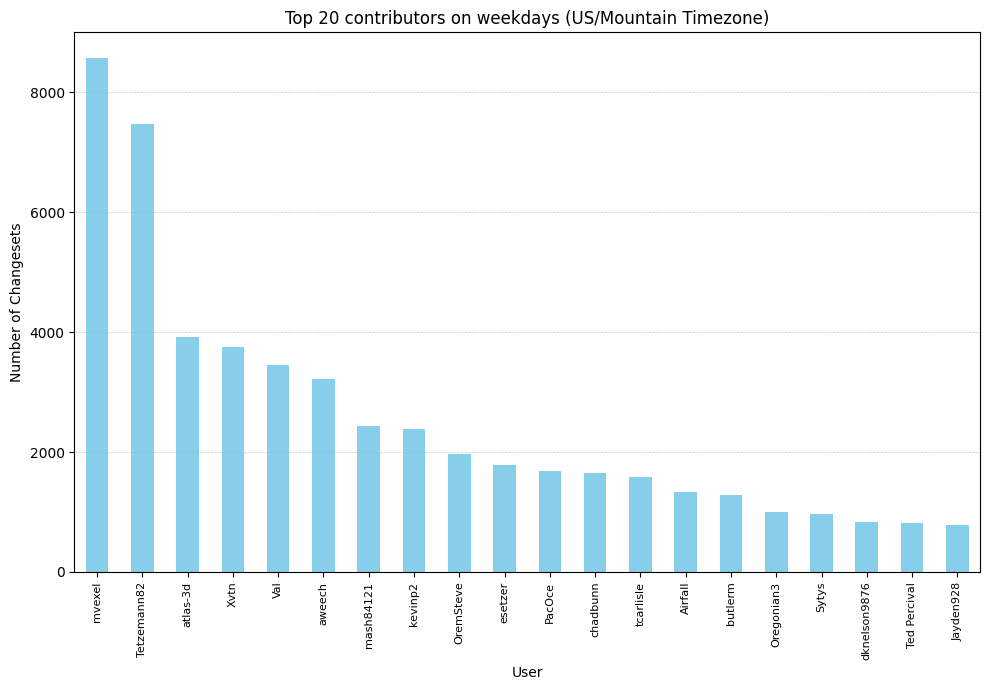

In [9]:
# same but for weekday vs weekend
df['weekday'] = df['created_at'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: True if x >= 5 else False)
weekend_users = df[df['is_weekend'] == True]['user'].unique().tolist()

df_weekend_users = df[df['user'].isin(weekend_users)]
df_weekend_users['weekday'] = df_weekend_users['created_at'].dt.weekday
df_weekend_users['is_weekend'] = df_weekend_users['weekday'].apply(lambda x: True if x >= 5 else False)
weekend_changesets = df_weekend_users[df_weekend_users['is_weekend'] == True]

top_weekend_users = weekend_changesets['user'].value_counts().head(20)
plt.figure(figsize=(10, 7))
top_weekend_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 contributors on weekends (US/Mountain Timezone)')
plt.xlabel('User')
plt.ylabel('Number of Changesets')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# same for weekday
weekday_users = df[df['is_weekend'] == False]['user'].unique().tolist()

df_weekday_users = df[df['user'].isin(weekday_users)]
df_weekday_users['weekday'] = df_weekday_users['created_at'].dt.weekday
df_weekday_users['is_weekend'] = df_weekday_users['weekday'].apply(lambda x: True if x >= 5 else False)
weekday_changesets = df_weekday_users[df_weekday_users['is_weekend'] == False]

top_weekday_users = weekday_changesets['user'].value_counts().head(20)
plt.figure(figsize=(10, 7))
top_weekday_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 contributors on weekdays (US/Mountain Timezone)')
plt.xlabel('User')
plt.ylabel('Number of Changesets')
plt.xticks(rotation=90)
plt.xticks(fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

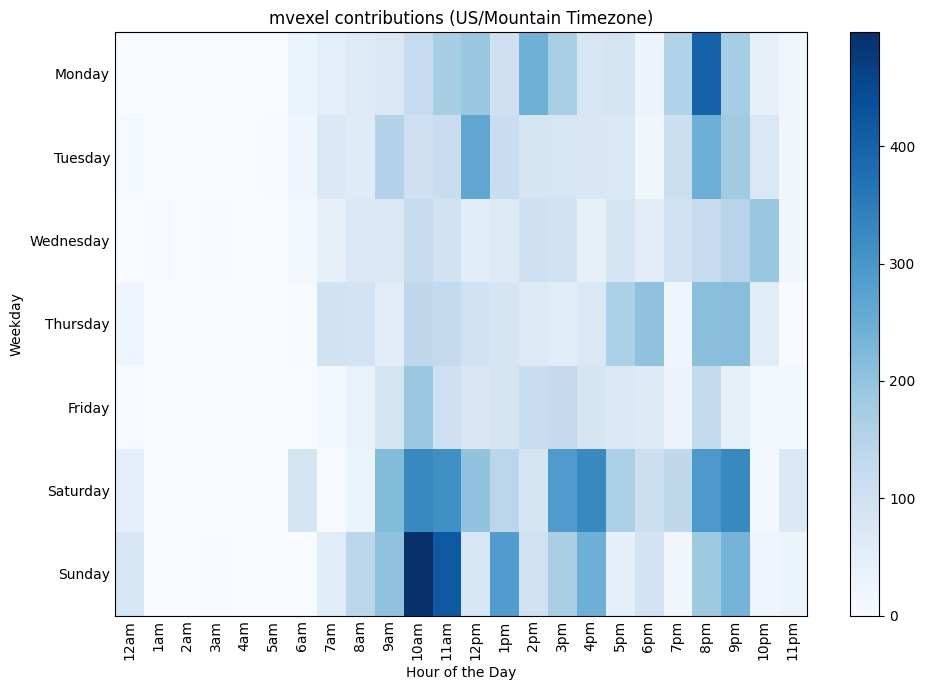

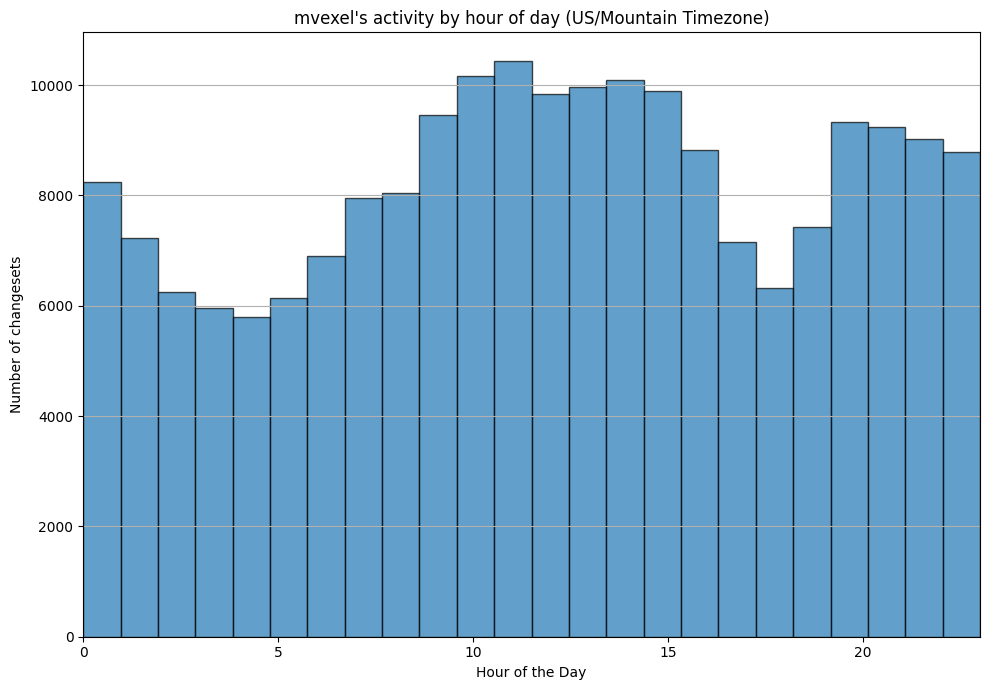

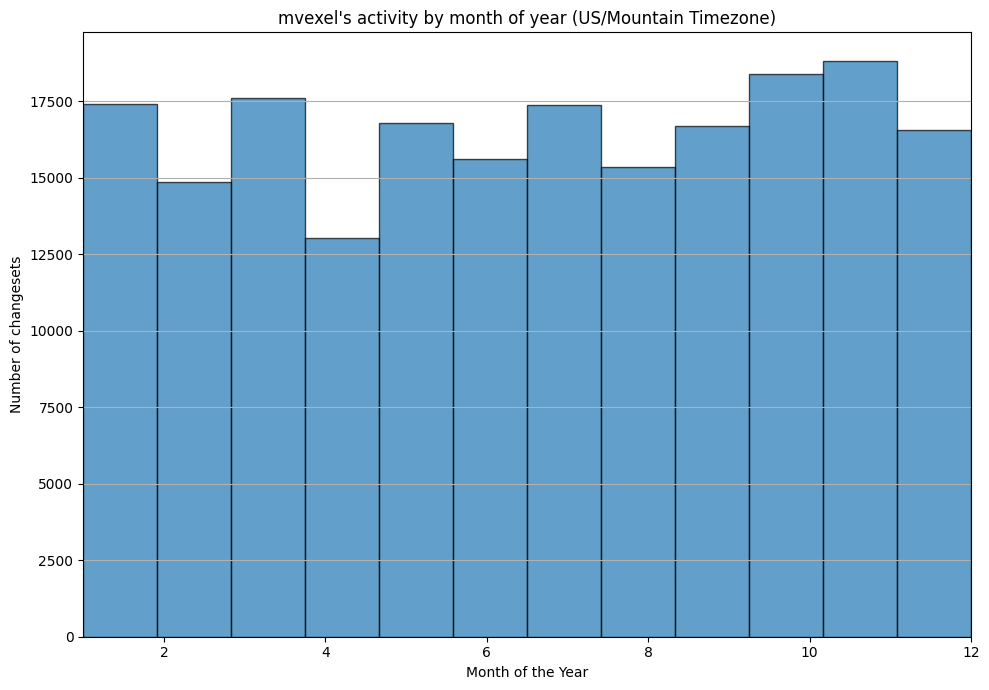

In [10]:
# now make a heatmap of contributions for user mvexel
mvexel_changesets = df[df['user'] == 'mvexel']
mvexel_changesets['weekday'] = mvexel_changesets['created_at'].dt.weekday
mvexel_changesets['hour_of_day'] = mvexel_changesets['created_at'].dt.hour
mvexel_changesets_hourly = mvexel_changesets.groupby(['weekday', 'hour_of_day']).size().reset_index(name='count')
mvexel_changesets_hourly_pivot = mvexel_changesets_hourly.pivot(index='weekday', columns='hour_of_day', values='count')
# Ensure the pivot table has all hours from 0 to 23
mvexel_changesets_hourly_pivot = mvexel_changesets_hourly_pivot.reindex(columns=range(24), fill_value=0)

plt.figure(figsize=(10, 7))
plt.title('mvexel contributions (US/Mountain Timezone)')

# X-axis configuration
plt.xticks([])
plt.gca().set_xticks(np.arange(24), minor=True)  # Change here
hours = [(f"{i % 12 if i % 12 != 0 else 12}{'am' if i < 12 else 'pm'}") for i in range(24)]
plt.gca().set_xticklabels(hours, minor=True, rotation=90)
plt.gca().tick_params(axis='x', which='both', length=0)
plt.xlabel('Hour of the Day')

# Y-axis configuration
plt.ylabel('Weekday')
plt.yticks([])
plt.gca().set_yticks(np.arange(7), minor=True)  # Change here
plt.gca().set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], minor=True)
plt.gca().tick_params(axis='y', which='both', length=0)

plt.imshow(mvexel_changesets_hourly_pivot.fillna(0), cmap='Blues', origin='upper', aspect='auto') 
plt.colorbar()
plt.tight_layout()
plt.show()


# histogram of hours of the day
plt.figure(figsize=(10, 7))
plt.hist(df['hour_of_day'], bins=24, edgecolor='black', alpha=0.7)
plt.title('mvexel\'s activity by hour of day (US/Mountain Timezone)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of changesets')
# make sure there's no space between the y axis and the first bar
plt.gca().set_xlim(left=0)
# and between the last bar and the right axis
plt.gca().set_xlim(right=23)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# histogram for month of the year
plt.figure(figsize=(10, 7))
plt.hist(df['created_at'].dt.month, bins=12, edgecolor='black', alpha=0.7)
plt.title('mvexel\'s activity by month of year (US/Mountain Timezone)')
plt.xlabel('Month of the Year')
plt.ylabel('Number of changesets')
# make sure there's no space between the y axis and the first bar
plt.gca().set_xlim(left=1)
# and between the last bar and the right axis
plt.gca().set_xlim(right=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [13]:
# what's up with Sunday morning between 10am and noon?
mvexel_changesets_sunday_morning = mvexel_changesets[(mvexel_changesets['weekday'] == 6) & (mvexel_changesets['hour_of_day'] >= 10) & (mvexel_changesets['hour_of_day'] <= 12)]

mvexel_changesets_sunday_morning.head(20)

# create a word cloud of all comments

comment_words = ' '
stopwords = set(STOPWORDS)

# iterate through the csv file and get the comments where they exist (not guaranteed)
for changeset in mvexel_changesets_sunday_morning:
    comment = changeset.get('comment')
    if comment is None:
        continue
    # typecast each val to string
    comment = str(comment)
    # split the value
    tokens = comment.split()
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()